# Mugration Analysis

## Setup

---

### Module Imports

In [1]:
from Bio import Phylo
from treetime.utils import parse_dates
from treetime import wrappers

import copy
import os
import sys

import pandas
import numpy as np

import matplotlib.pyplot as plt
from matplotlib import colors, lines, patches, gridspec

### Input File Paths

In [2]:
'''
tree_path = str(snakemake.input.tree)
aln_path = str(snakemake.input.snp_aln)
metadata_path = str(snakemake.input.metadata)
treetime_path = str(snakemake.output.treetime)
'''
tree_path = "../../docs/results/2020-11-09/iqtree/iqtree-core_chromosome.filter5.treefile"
metadata_path = "../../docs/results/2020-12-08/metadata/metadata.txt"
outdir = "../../docs/results/2020-12-08/treetime/"

### Constants and Variables

In [3]:
NAME_COL = "Sample"
DATES_COL = "Date"
ATTRIBUTE = "Country"
#ATTRIBUTE = "Biovar"
ALRT_THRESH = 80
UFBOOT_THRESH = 95
MUG_CONF_THRESH = 0.90
MUG_CONF_RATIO = 2
NO_DATA_CHAR = "NA"
COLOR_PAL = "rainbow"
COLBAR_MAX_ROW = 10

### Global Plot Config

In [61]:
# Setup general plot variables
high_col = "red"
low_col = "black"
term_col = "grey"
thresh_col = "blue"

SM_FONT = 5
MED_FONT = 8
LG_FONT = 10

plt.rc('font', size=SM_FONT)          # controls default text sizes
plt.rc('figure', titlesize=LG_FONT)  # fontsize of the figure title
#plt.rc('axes', labelsize=MED_FONT)    # fontsize of the x and y labels

## Analysis

---

### Convert Newick Tree to Temp XML

In [4]:
tmp_xml = os.path.join(os.path.dirname(tree_path), "temp.xml")
Phylo.convert(tree_path, "newick", tmp_xml, "phyloxml")

1

### Rename Internal Nodes and Parse Confidence

In [5]:
# Read in the new tree
tree_div = Phylo.read(tmp_xml, "phyloxml")
# Deepest nodes first
tree_div.ladderize(reverse=True)

# Counters
node_i = 0
branches_high_support = 0
branches_low_support = 0

alrt_high_vals = []
alrt_low_vals = []

ufboot_high_vals = []
ufboot_low_vals = []

for c in tree_div.find_clades():
    if not c.name:
        continue

    # Assuming IQTREE was run to have format aLRT/UFBoot.
    name_split = c.name.split("/")
    
    # If it's a terminal node
    if c.is_terminal():
        c.color = "grey"
    
    # Check if the name has 'accidentally' become the confidence vals
    if (
        len(name_split) == 2 
        and float(name_split[0]) >= 0 and float(name_split[1]) <= 100
        and float(name_split[1]) >= 0 and float(name_split[1])  <= 100
        ):

        # Name the internal node
        c.name = "NODE" + str(node_i)
        
        # Assign confidence values
        alrt_val = float(name_split[0])
        alrt_conf = Phylo.PhyloXML.Confidence(alrt_val, type="alrt")
        
        ufboot_val = float(name_split[1])
        ufboot_conf = Phylo.PhyloXML.Confidence(ufboot_val, type="ufboot")
        
        c.confidences.append(alrt_conf)
        c.confidences.append(ufboot_conf)
        
        c.color = "black"       
        # Strong branch support: alrt >= 80, UFboot >= 95
        if alrt_val >= ALRT_THRESH:
            alrt_high_vals.append(alrt_val)
        else:
            alrt_low_vals.append(alrt_val)
            
        if ufboot_val >= UFBOOT_THRESH:
            ufboot_high_vals.append(ufboot_val)
        else:
            ufboot_low_vals.append(ufboot_val)
            
        if alrt_val >= ALRT_THRESH and ufboot_val >= UFBOOT_THRESH:
            c.color = "red"
            branches_high_support += 1
        else:
            branches_low_support += 1
        
        # Increment node counter
        node_i += 1

# Sum branches with support
branches_num = branches_low_support + branches_high_support
branches_high_perc = (branches_high_support / branches_num) * 100

### Plot Branch Supports

1

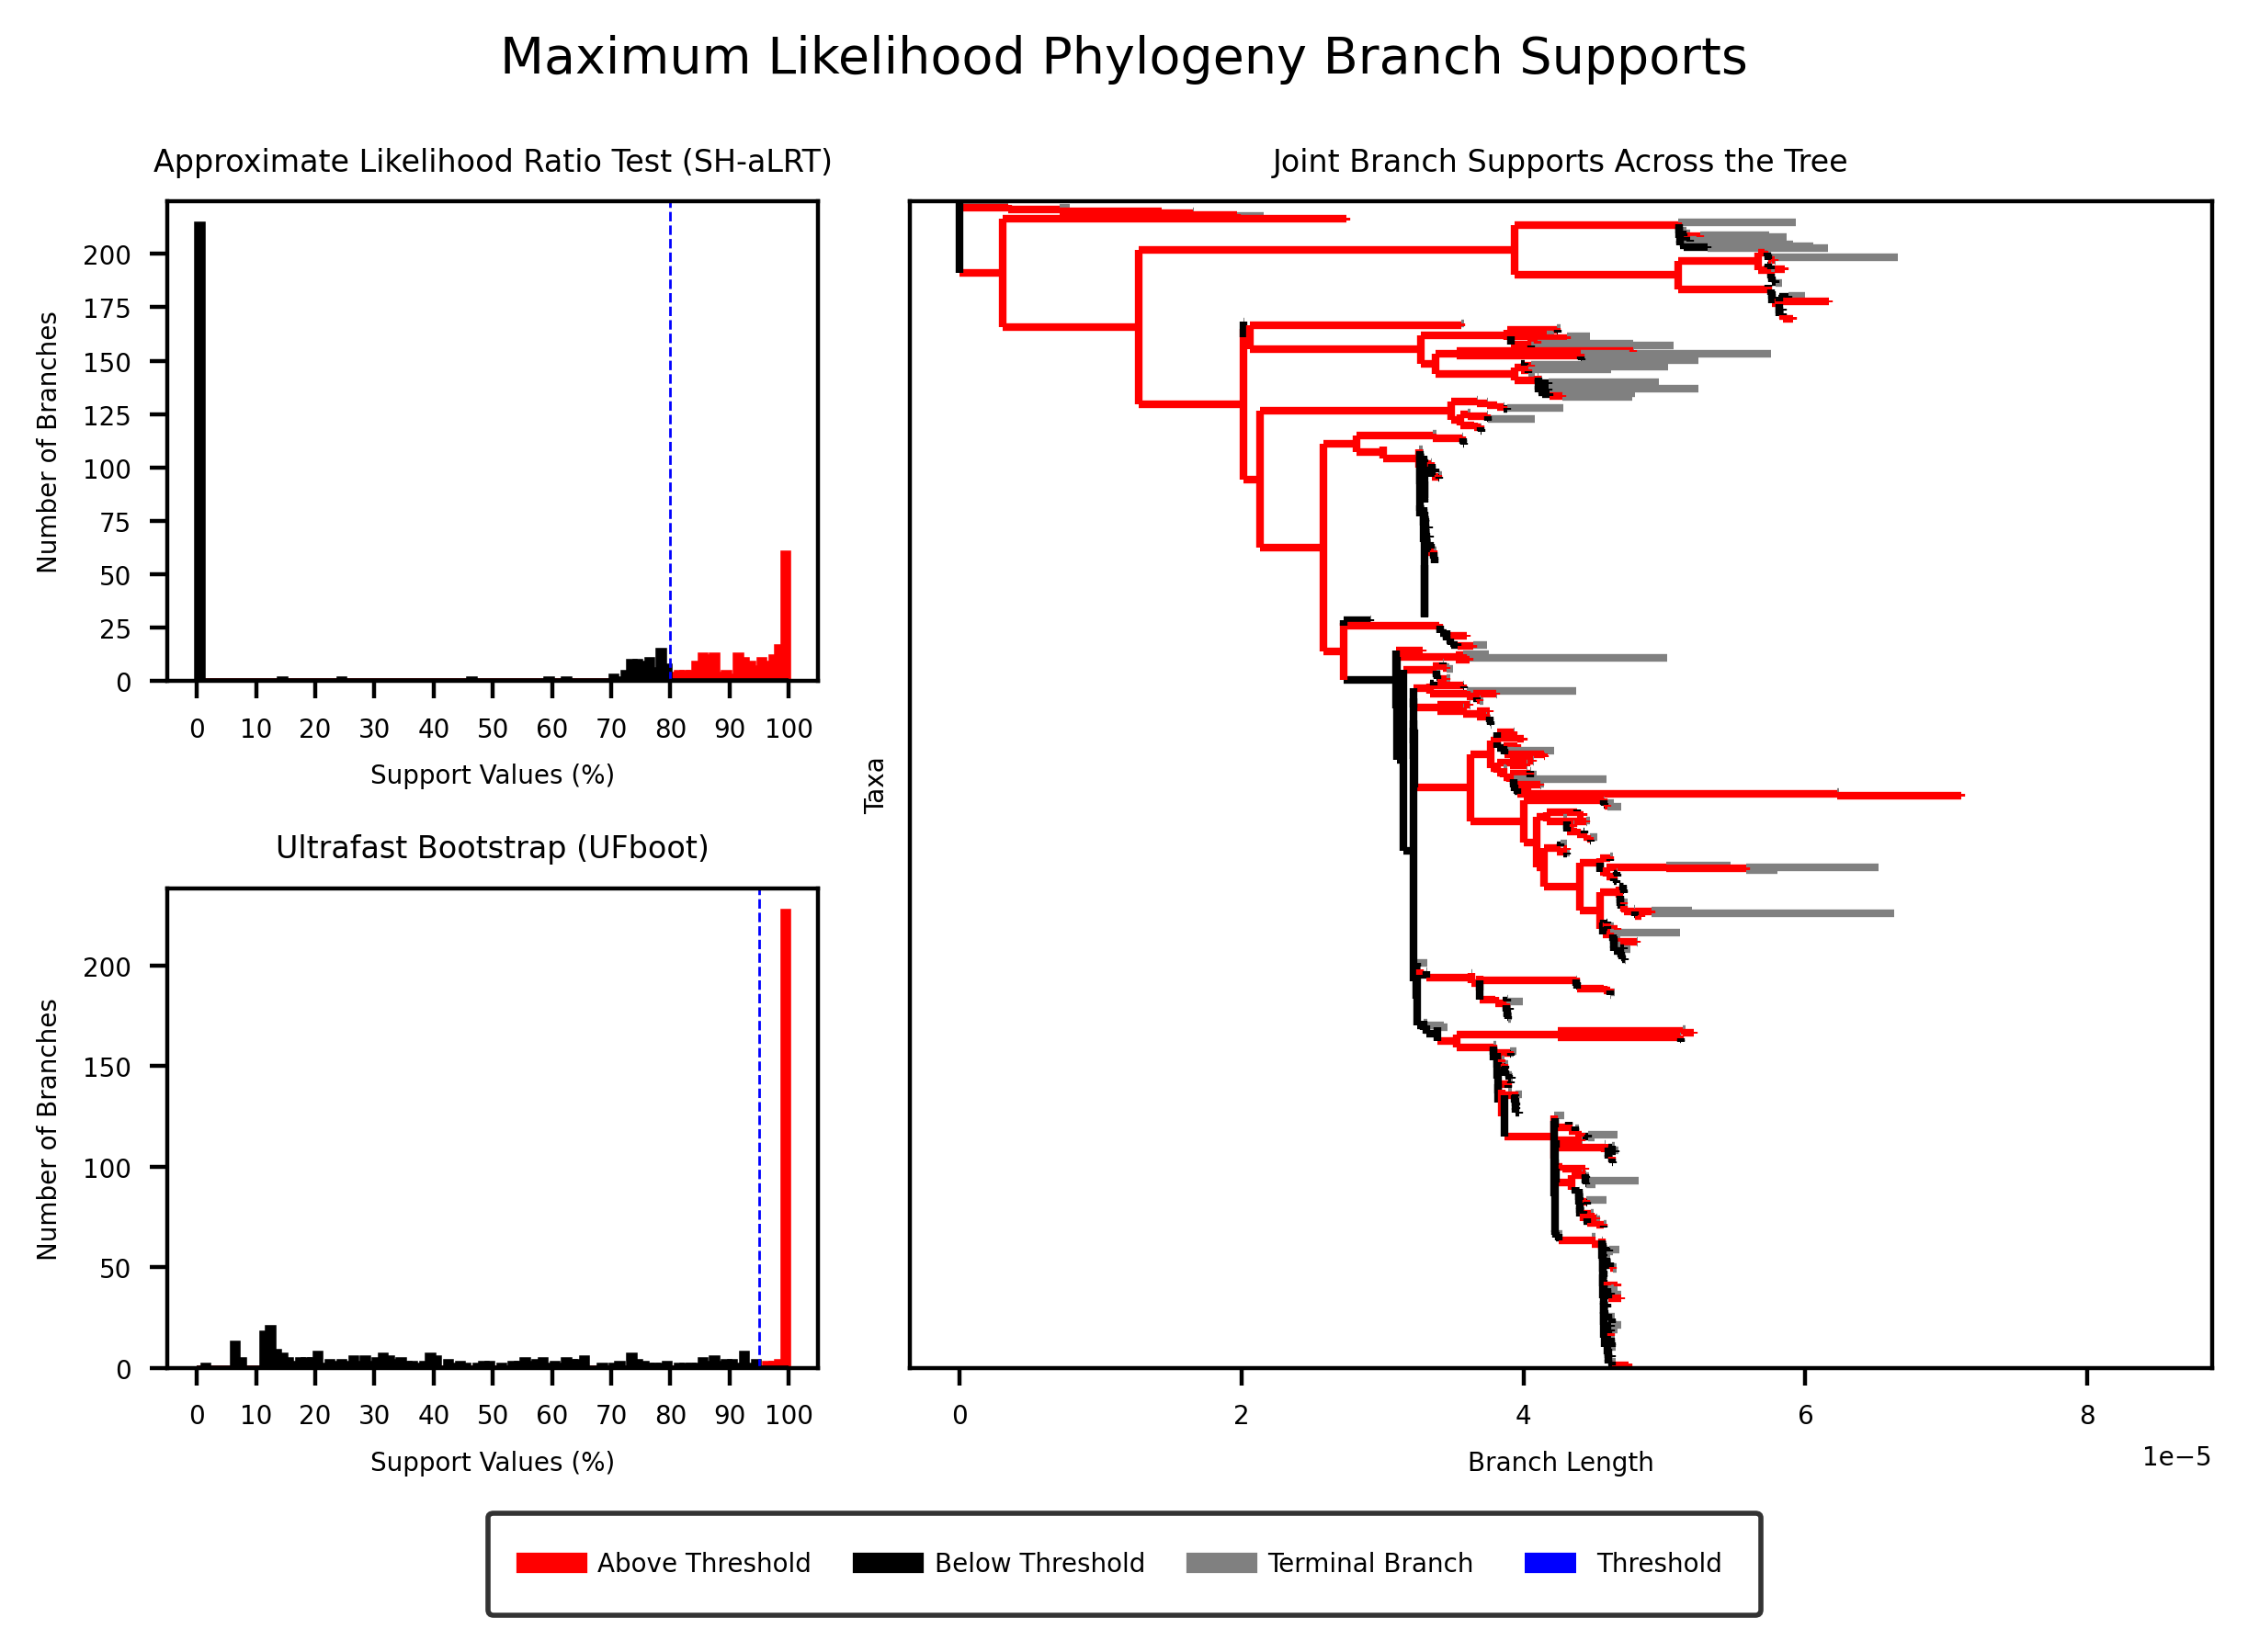

In [58]:
fig = plt.figure(constrained_layout=True, dpi=400)

# Setup the grid
gs = gridspec.GridSpec(2, 3, figure=fig)
ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[1, 0])
ax3 = fig.add_subplot(gs[0:, 1:3])

# Local plot variables
hist_bins = [x for x in range(0,101,1)]
xticks_major = [x for x in range(0,101,10)]


# aLRT Axis
ax1.hist(alrt_high_vals, color = high_col, edgecolor = high_col, bins = hist_bins)
ax1.hist(alrt_low_vals, color = low_col, edgecolor = low_col, bins = hist_bins)
ax1.axvline(x=ALRT_THRESH, color=thresh_col, linewidth=0.5, linestyle='--')
ax1.set_xticks(xticks_major, minor=False)
ax1.set_xticklabels(xticks_major)
ax1.set_xlabel("Support Values (%)")
ax1.set_ylabel('Number of Branches')
ax1.set_title('Approximate Likelihood Ratio Test (SH-aLRT)')

# UFboot Axis
ax2.hist(ufboot_high_vals, color = 'red', edgecolor = 'red', bins=hist_bins)
ax2.hist(ufboot_low_vals, color = 'black', edgecolor = 'black', bins=hist_bins)
ax2.axvline(x=UFBOOT_THRESH, color="blue", linewidth=0.5, linestyle='--')
ax2.set_xticks(xticks_major, minor=False)
ax2.set_xticklabels(xticks_major)
ax2.set_ylabel('Number of Branches')
ax2.set_xlabel("Support Values (%)")
ax2.set_title('Ultrafast Bootstrap (UFboot)')

# Phylogeny
tree_div.ladderize(reverse=False)
Phylo.draw(tree_div,
           axes=ax3,
           show_confidence=False, 
           label_func = lambda x:'', 
           do_show=False)
ax3.set_xlabel('Branch Length')
ax3.set_ylabel('Taxa')
ax3.set_yticks([])
ax3.set_yticklabels([])
ax.set_ylim(-20,len(tree_div.get_terminals())+20)
ax3.set_title("Joint Branch Supports Across the Tree")

fig.suptitle("Maximum Likelihood Phylogeny Branch Supports")

# Legend
legend_lines = [lines.Line2D([0], [0], color="red", lw=4),
                lines.Line2D([0], [0], color="black", lw=4),
                lines.Line2D([0], [0], color="grey", lw=4),
                lines.Line2D([0], [0], color="blue", lw=4, ls="--"),
               ]

legend_labels = ["Above Threshold",
                 "Below Threshold",
                 "Terminal Branch",
                 "Threshold"]
fig.legend(legend_lines, 
           legend_labels,
           ncol=len(legend_labels),
           loc="center", 
           bbox_to_anchor=(0.5, -0.05),
           frameon=True,
           borderpad=1.5,
           edgecolor="black") 

# Save figure
out_path = os.path.join(outdir, "treetime_branch-support.jpg") 
plt.savefig(out_path, dpi=400, bbox_inches = "tight")

# Save Tree File
out_path = os.path.join(outdir, "treetime_branch-support.xml" )
Phylo.write(tree_div, 
            out_path,
            "phyloxml")

In [67]:
print(" Branches: {0:d} \n High Confidence: {1:d} ({2:.0f}%)".format(branches_num, branches_high_support, branches_high_perc))


 Branches: 496 
 High Confidence: 187 (38%)


### Parse Metadata

In [59]:
# Parse the metadata
states = pandas.read_csv(metadata_path, sep='\t')

# Tell treetime which column is the taxon name
if NAME_COL in states.columns:
    taxon_name = NAME_COL

# Tell treetime which column is the attribute for mugration
if ATTRIBUTE in states.columns:
    attr = ATTRIBUTE

# Get tips names
tree_tip_names = [t.name for t in tree_div.get_terminals()]

## Analysis

### Metadata Summary

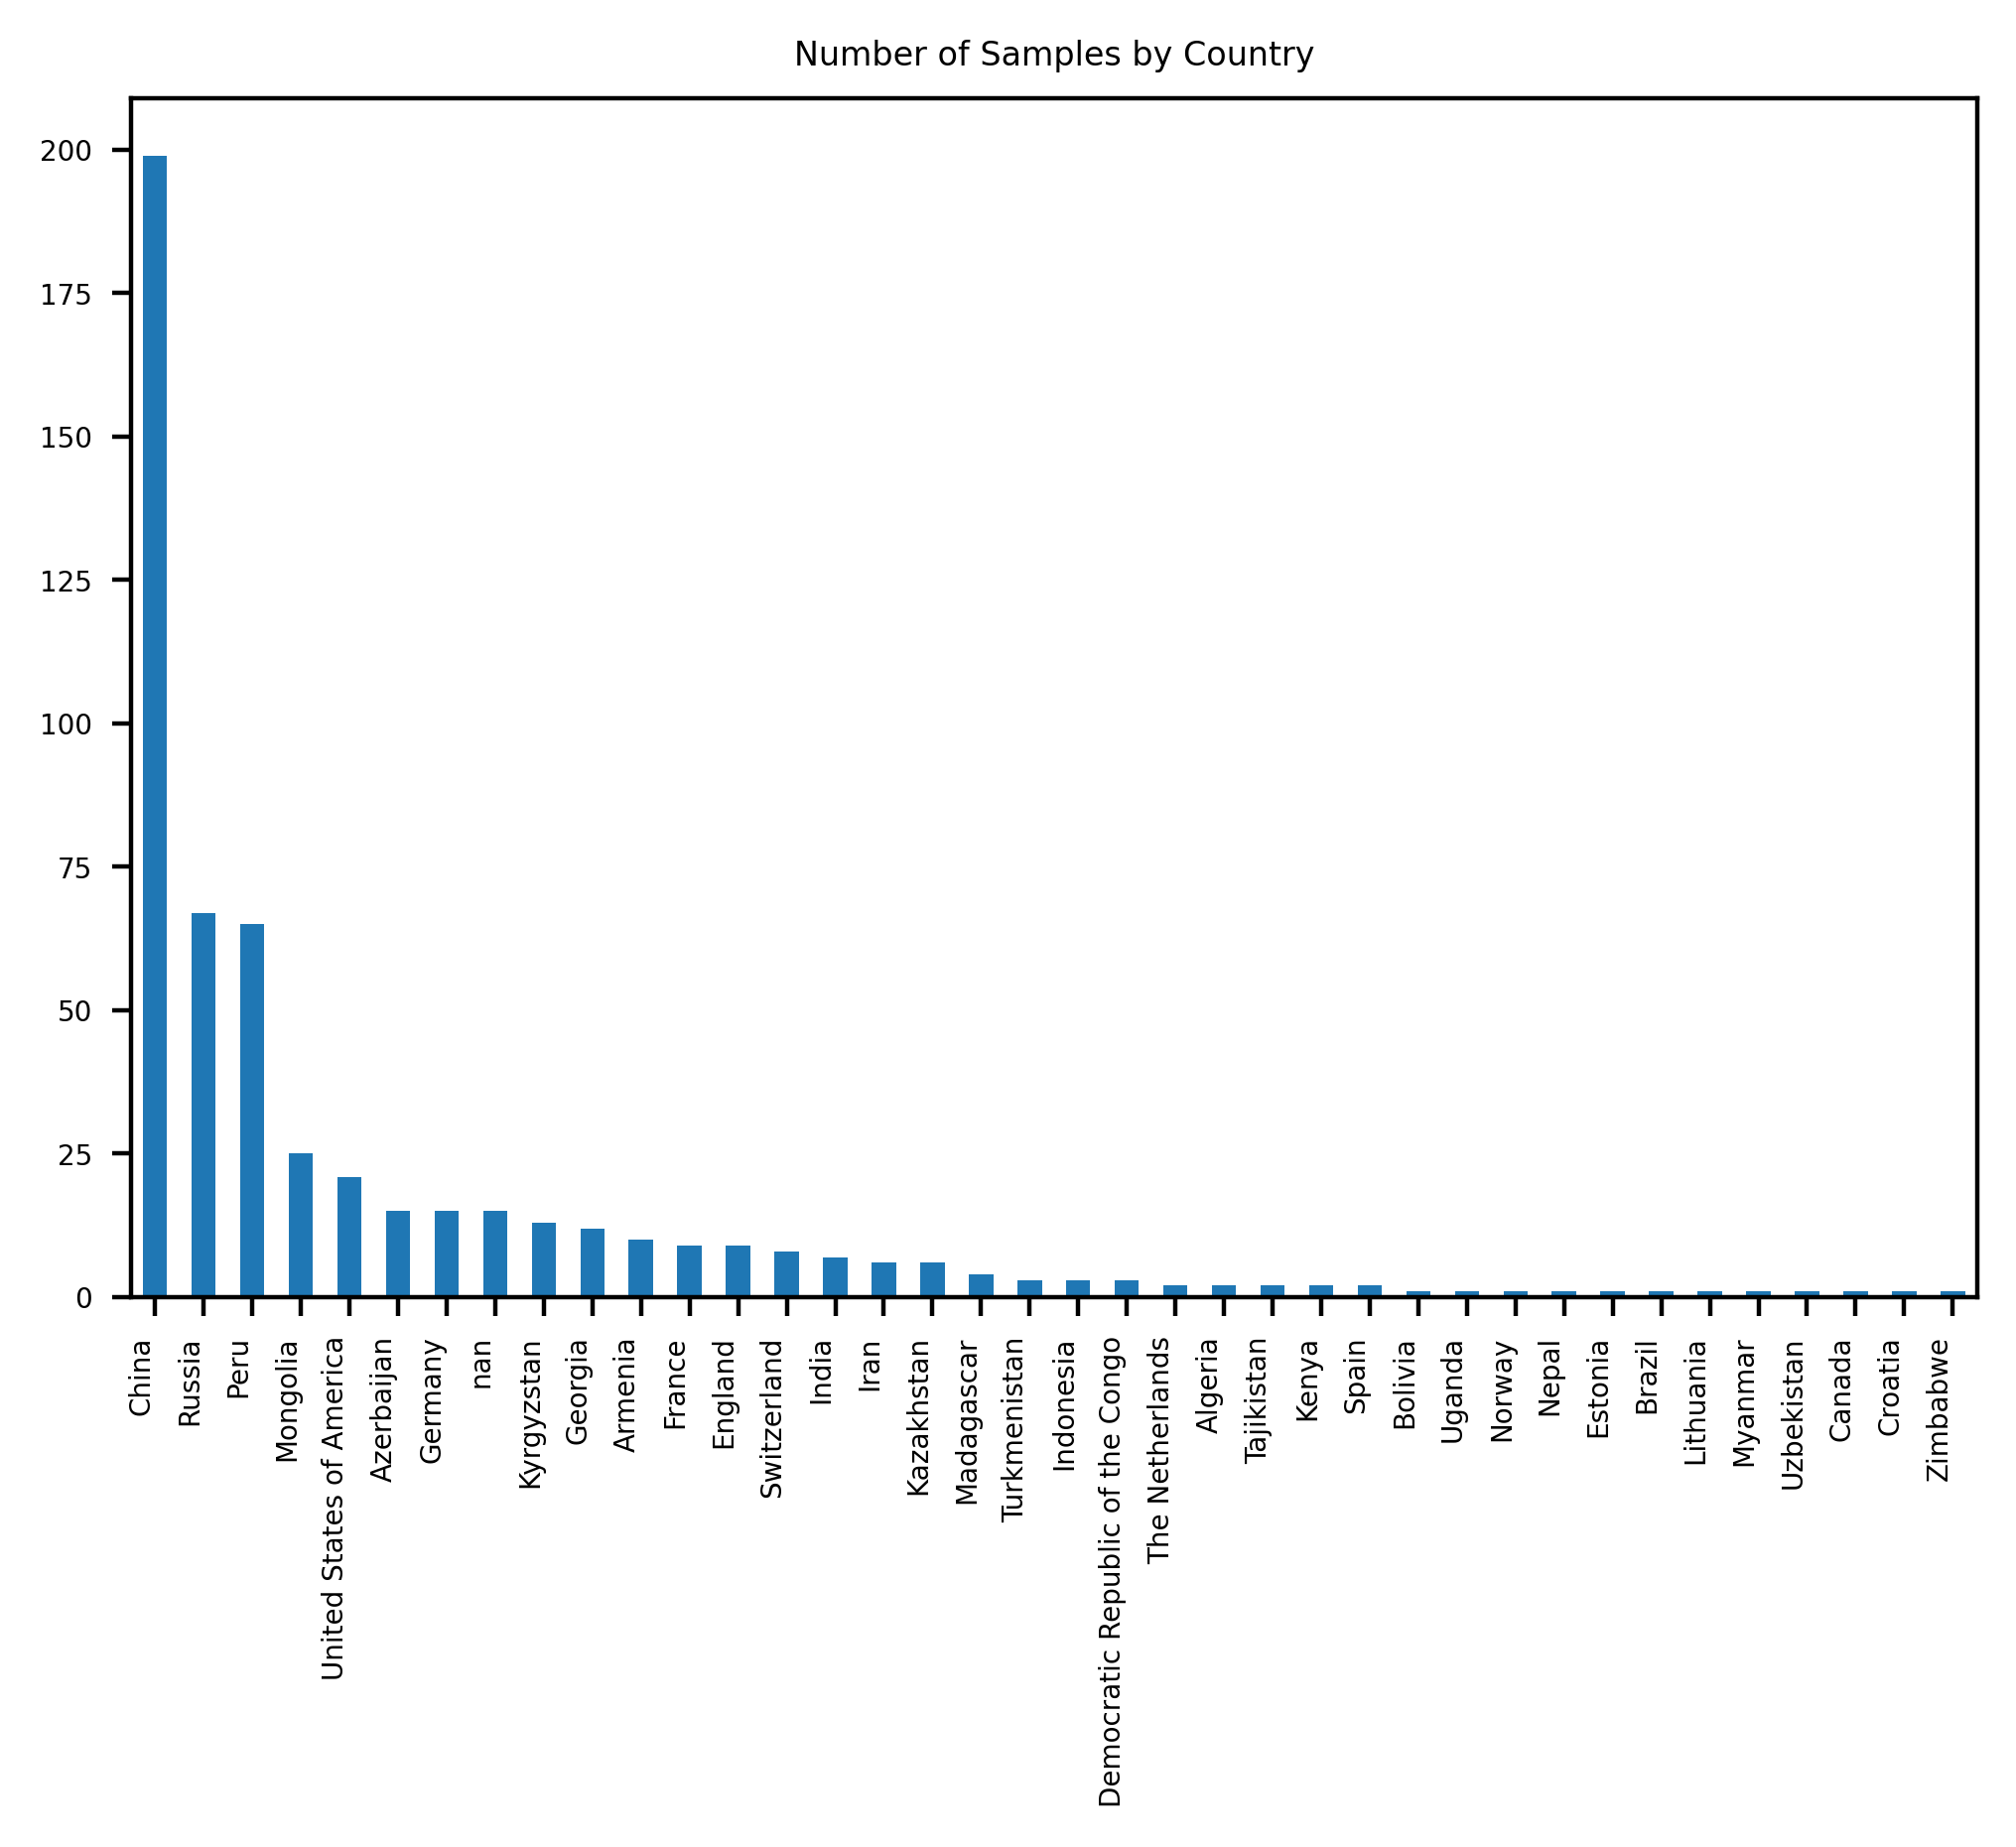

In [60]:
plt.figure(dpi=400)
ax = plt.subplot()

states[ATTRIBUTE].value_counts(dropna=False).plot(kind='bar')
xticklabels = [item.get_text() for item in ax.get_xticklabels()]

ax.set_xticklabels(xticklabels, rotation = 90, ha="right")

plt.title("Number of Samples by {}".format(ATTRIBUTE))
out_path = os.path.join(outdir, "treetime_{}_hist.jpg".format(ATTRIBUTE.lower())) 
plt.savefig(out_path, 
            dpi=400, 
            bbox_inches = "tight")


### Mugration Estimation

In [ ]:
# Map the taxon name to the mugration attribute
leaf_to_attr = {x[taxon_name]:str(x[attr]) for xi, x in states.iterrows()
                    if x[attr]!=NO_DATA_CHAR and x[attr]}
print(leaf_to_attr)

# Optional: simplify the Mictorus biovar
for leaf in leaf_to_attr:
    leaf_attr = leaf_to_attr[leaf]
    if leaf_attr in ["Ulegeica", "Altaica", "Talassica", "Hissarica", "Xilingolensis", "Caucasica"]:
        leaf_to_attr[leaf] = "Microtus"

In [ ]:
%%capture --no-stderr cap 

# Run the mugration (default nan comes from previous step)
out_path = os.path.join(outdir, "treetime_{}_mug.log".format(ATTRIBUTE.lower())) 
mug, letter_to_state, reverse_alphabet = wrappers.reconstruct_discrete_traits(tree=tree_div, 
                                                                     traits=leaf_to_attr, 
                                                                     missing_data="nan",
                                                                     #pc=pc, 
                                                                     #sampling_bias_correction=sampling_bias_correction, 
                                                                     verbose=4, 
                                                                     #weights=params.weights
                                                                    )
with open(out_path, 'w') as f:
    f.write(cap.stdout)

In [ ]:
# All unique states from mugration
unique_states = sorted(letter_to_state.values())
print(unique_states)
#print(len(unique_states))

### Add Node Properties

In [ ]:
node_all_conf = {}
node_high_conf = {}
node_low_conf = {}

terminal_names = [tip.name for tip in mug.tree.get_terminals()]

for c in mug.tree.find_clades():
    # Store the name and confidence for the state with the most support
    state_max_name = letter_to_state[c.cseq[0]]
    state_conf_list = c.marginal_profile[0]

    # Find the two largest values
    largest = 0
    second_largest = 0
    for conf in state_conf_list:
        if conf > largest:
            second_largest = largest
            largest = conf
        elif largest > conf > second_largest:
            second_largest = conf
        
    # Add the node value to the list
    node_all_conf[c.name] = largest
    
    c.other = []

    # Store all the states and confidence values
    for state_name,state_conf in zip(unique_states, state_conf_list):
        attr_other = Phylo.PhyloXML.Other(tag=state_name, value="{:0.4f}".format(state_conf), namespace=ATTRIBUTE)
        c.other.append(attr_other)
        
    # Option 1: Assign the maximum value based on threshold
    if largest < MUG_CONF_THRESH:
        # Exclude terminals.tips
        if c.name not in terminal_names:
            node_low_conf[c.name] = largest
        attr_other = Phylo.PhyloXML.Other(tag="Low Confidence", value="{:0.4f}".format(largest), namespace=ATTRIBUTE + "_assign")
        
    else:
        if c.name not in terminal_names:
            node_high_conf[c.name] = largest
        attr_other = Phylo.PhyloXML.Other(tag=state_max_name, value="{:0.4f}".format(largest), namespace=ATTRIBUTE + "_assign")
    # Option 2: Assign the maximum value based on ratio           
    """
    if second_largest != 0 and (largest / second_largest < MUG_CONF_RATIO):
        node_low_conf[c.name] = largest
        attr_other = Phylo.PhyloXML.Other(tag="Low Confidence", value="{:0.4f}".format(largest), namespace=ATTRIBUTE + "_assign")
                
    else:           
        node_high_conf[c.name] = largest
        attr_other = Phylo.PhyloXML.Other(tag=state_max_name, value="{:0.4f}".format(largest), namespace=ATTRIBUTE + "_assign")      
    """    
    c.other.append(attr_other)

print("ALL: ", len(node_all_conf))
high_conf_num = len(node_high_conf)
print("HIGH CONFIDENCE: ", high_conf_num)
low_conf_num = len(node_low_conf)
print("LOW CONFIDENCE: ", low_conf_num)
internal_nodes_num = high_conf_num + low_conf_num
print("INTERNAL NODES: ", internal_nodes_num)

high_conf_perc = (high_conf_num / internal_nodes_num) * 100
low_conf_perc = (low_conf_num / internal_nodes_num) * 100

fig = plt.figure(dpi=400)
ax = plt.subplot()

#plt.hist(node_all_conf.values(), color = 'blue', edgecolor = 'black', bins=50, label="Confidence Distribution")
plt.hist(node_high_conf.values(), color = 'red', edgecolor = 'red', bins=50, label="High Confidence Nodes")
plt.hist(node_low_conf.values(), color = 'black', edgecolor = 'black', bins=50, label="Low Confidence Nodes")
plt.axvline(x=MUG_CONF_THRESH, color="blue", linewidth=0.5, linestyle='--', label="Confidence Threshold")

# Labels
plt.xlabel('Confidence')
plt.ylabel('Number of Nodes')
plt.title("Internal Node Confidence by {}".format(ATTRIBUTE))

# Legend
#blue_patch = patches.Patch(color='blue', label='Confidence Distribution')
#red_line = lines.Line(color='red', label='Confidence Threshold')
#plt.legend(handles=[blue_patch])

plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)

perc_string = " Internal Nodes: {0:d} \n High Confidence: {1:d} ({2:.0f}%)".format(internal_nodes_num, high_conf_num, high_conf_perc)
                                                                                
# Add text
plt.text(1.05, 0.5, 
         perc_string, 
         horizontalalignment='left', 
         verticalalignment='center', 
         transform=ax.transAxes)

out_path = os.path.join(outdir, "treetime_{}_confidence_hist.jpg".format(ATTRIBUTE.lower())) 
plt.savefig(out_path, 
            dpi=400, 
            bbox_inches = "tight")



### Draw Mugration Tree

In [ ]:
# Make a copy of the tree to edit values
mug_tree_div = copy.deepcopy(mug.tree)
# Deepest nodes first
mug_tree_div.ladderize(reverse=False)

# Initialize the states with the low confidence 
ordered_states = ["Low Confidence"]

# Get the ladderized order of attributes
for t in mug_tree_div.get_terminals():
    for prop in t.other:
        if prop.namespace == ATTRIBUTE + "_assign" and prop.tag not in ordered_states:
            ordered_states.append(prop.tag)

# Number of states that need colors (exclude nan)
num_attr = len(unique_states[:-1])

# Create the custom color map
cmap = plt.get_cmap(COLOR_PAL,num_attr)
# Convert to a list of colors
cmaplist = [cmap(i) for i in range(cmap.N)]

# force the first color entry to be grey
cmaplist = [(.5, .5, .5, 1.0)] + cmaplist 
num_attr = num_attr + 1

# create the new map
cmap = colors.LinearSegmentedColormap.from_list(
    'Custom cmap', cmaplist, num_attr)

cmaplist = cmap(np.linspace(0, 1, num_attr))
hex_list = [colors.to_hex(col) for col in cmaplist]

hex_dict = {}

# Assign states colors based on tip order (Low Conf first as grey)
for state,hex_col in zip(ordered_states, hex_list):
    print(state,hex_col)
    hex_dict[state] = hex_col

# Deepest nodes last
mug_tree_div.ladderize(reverse=True)

# Color branches by attr
for c in mug_tree_div.find_clades():
    for prop in c.other:
        if prop.namespace == ATTRIBUTE + "_assign":
            # Color by category
            c.color = hex_dict[prop.tag]


In [ ]:
# Draw the tree
# ----------------------------------
# Deepest nodes last
mug_tree_div.ladderize(reverse=True)

fig = plt.figure(dpi=400)
ax = plt.subplot()

# Draw tree to the canvas
Phylo.draw(mug_tree_div, 
           axes=ax, 
           show_confidence=False, 
           label_func = lambda x:'', 
           do_show=False)

# Root branch length set to 0.001
ax.set_xlim(0.000999,0.00108)
ax.set_ylim(-20,len(mug_tree_div.get_terminals())+20)
ax.set_yticks([])
#ax.set_xticks([])

# Create the colorbar
norm = colors.Normalize(vmin=0.5,vmax=num_attr + 0.5)
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cbar = plt.colorbar(sm, ticks=np.linspace(1,num_attr,num_attr))
# Add conf info to Low conf label
#ordered_states[0] = "Low Confidence \n (confidence < {})".format(MUG_CONF_THRESH)
ordered_states[0] = "Low Confidence"
cbar.ax.set_yticklabels(ordered_states) 

plt.xlabel("Branch Length")
plt.ylabel("Taxa")
plt.title("Treetime Mugration: {}".format(ATTRIBUTE))
out_path = os.path.join(outdir, "treetime_{}_mug_tree.jpg".format(ATTRIBUTE.lower()))  
plt.savefig(out_path, dpi=400, bbox_inches = "tight")

# Write Tree File
out_path = os.path.join(outdir, "treetime_{}_mug_tree.xml".format(ATTRIBUTE.lower() ))
Phylo.write(mug_tree_div, 
            out_path,
            "phyloxml")

### Draw Mugration Confidence Tree

In [ ]:
# Deepest nodes last
mug_tree_div.ladderize(reverse=True)

for c in mug_tree_div.find_clades():
    for prop in c.other:
        if prop.namespace == ATTRIBUTE + "_assign":
            # color by confidence
            c.color = "black"
            if float(prop.value) >= MUG_CONF_THRESH:
                c.color = "red"

fig = plt.figure(dpi=400)
ax = plt.subplot()

# Draw tree to the canvas
Phylo.draw(mug_tree_div, 
           axes=ax, 
           show_confidence=False, 
           label_func = lambda x:'', 
           do_show=False)

# Root branch length set to 0.001
# Ticks
ax.set_xlim(0.000999,0.00108)
ax.set_ylim(-20,len(mug_tree_div.get_terminals())+20)
ax.set_yticks([])
plt.xticks(fontsize=7)

# Labels
plt.xlabel("Branch Length")
plt.ylabel("Taxa")
plt.title("Mugration {} Confidence".format(ATTRIBUTE))

# Legend
legend_lines = [lines.Line2D([0], [0], color="red", lw=4),
                lines.Line2D([0], [0], color="black", lw=4)]

ax.legend(legend_lines, 
          ["High Confidence)".format(MUG_CONF_THRESH),
           "Low Confidence"],
          bbox_to_anchor=(1.0, 1.0), 
          loc='upper left',)

# Write to file
out_path = os.path.join(outdir, "treetime_{}_mug_conf_tree.jpg".format(ATTRIBUTE.lower()))  
plt.savefig(out_path, dpi=400, bbox_inches = "tight")

## Cleanup

In [ ]:
os.remove(tmp_xml)